### Importing shit

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import random

### Loading pic

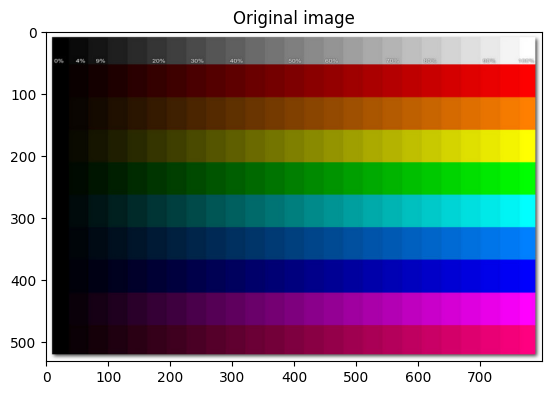

In [5]:
image = cv2.imread("index.png")
b,g,r = cv2.split(image)       # get b,g,r
rgb_image = cv2.merge([r,g,b])     # switch it to rgb
plt.imshow(rgb_image)
plt.title("Original image")
plt.show()

### Loading universal functions

In [6]:
def convolve(arr1, arr2):
    res = np.sum(np.multiply(arr1,arr2)) # Хуйни проверку на одинаковый shape
    #print(res)
    if res>255:
        res=255
    elif res<0:
        res=0
    #print(res)
    return int(res)
def extendBlack(arr, side):
    #Самым ублюдским образом приклеиваем нолики по сторонам к картинке
    arr = np.vstack([np.zeros((side//2,arr.shape[0])), arr.T, np.zeros((side//2,arr.shape[0]))]) 
    arr = np.vstack([np.zeros((side//2,arr.shape[0])), arr.T, np.zeros((side//2,arr.shape[0]))])
    return arr

def extendColor(arr, side):
    #либо самым ублюдским способом приклеиваем последнюю полоску пикселей с кадого края изображения
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8') 
    arr = np.vstack([np.array([arr.T[0]]*(side//2)), arr.T, np.array([arr.T[arr.T.shape[0]-1]]*(side//2))], dtype='uint8')
    return arr

### Gaussian blur

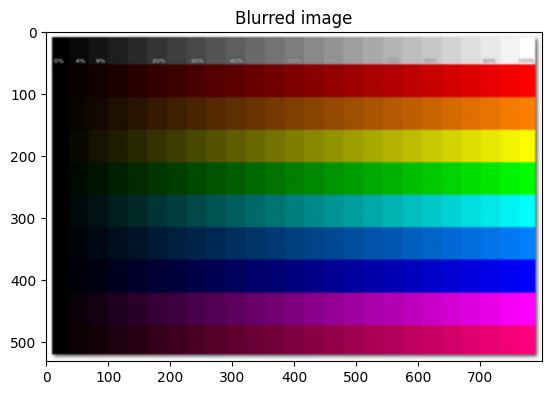

In [12]:
def gauss(x, sigma):
    return 1/np.sqrt(2*3.1416*sigma**2)*np.exp(-(x**2)/(2*sigma**2))
def blur(side, arr):
    sigma = (side-1)/6 if side>3 else 0.6
    diap = np.linspace(-(side - 1) / 2, (side - 1) / 2, side) #Задаем по стороне фильтра диап для генерации ядра типа [-2,-1,0,1,2]
    d1kern = np.array(list(map(gauss, diap, [sigma]*len(diap)))) #Считаем  1мерное ядро 
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    kern = np.outer(d1kern, d1kern) #Перемножением 1d ядер делаем 2d ядро
    arr = extendColor(arr, side)
   #Производим свертку, проходясь по каждому пикселю исходного изображения
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = convolve(sub, kern)
    return newarr
def blurRGB(image, side):
    (b, g, r) = cv2.split(image)
    b = blur(side, b)
    g = blur(side, g)
    r = blur(side, r)
    merged_rgb = cv2.merge([r,g,b])
    merged_bgr = cv2.merge([b,g,r]) 
    plt.imshow(merged_rgb)
    plt.title("Blurred image")
    plt.show()
    return merged_bgr
blurred = blurRGB(image, 7)

### Sharpening

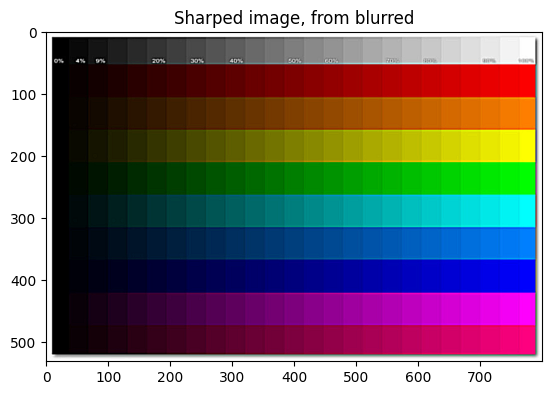

In [13]:
def sharp(arr):
    kern = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, 3)
    for y in range(1, arr.shape[1]-1):
        for x in range(1, arr.shape[0]-1):
            sub = arr[x-1:(x+2), y-1:(y+2)]
            #print(sub)
            #print(kern)
            newarr[x-1,y-1] = convolve(sub, kern)
        #print(y)
    return newarr
def sharpRGB(image):
    (b, g, r) = cv2.split(image)
    b = sharp(b)
    g = sharp(g)
    r = sharp(r)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.title("Sharped image, from blurred")
    plt.show()
sharpRGB(blurred)

### Median

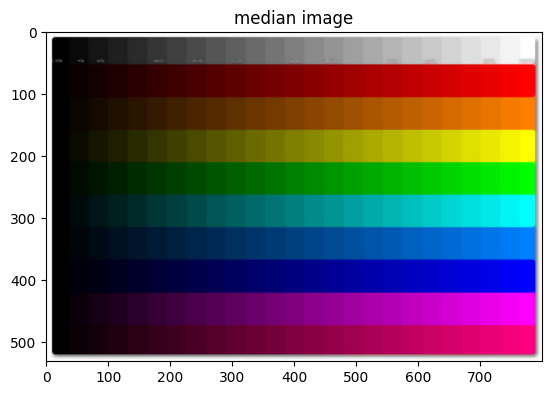

In [10]:
def median(arr, side):
    newarr = np.zeros(arr.shape, dtype = "uint8") #Делаем пустой массив размером с нашу картинку
    arr = extendColor(arr, side)
    for y in range(side//2, arr.shape[1]-side//2):
        for x in range(side//2, arr.shape[0]-side//2):
            sub = arr[x-side//2:(x+side//2+1), y-side//2:(y+side//2+1)]
            newarr[x-side//2,y-side//2] = np.sort(sub.flatten())[side**2//2]
    return newarr
def medianRGB(image, side):
    (b, g, r) = cv2.split(image)
    b = median(b, side)
    g = median(g, side)
    r = median(r, side)
    merged_rgb = cv2.merge([r,g,b])
    plt.imshow(merged_rgb)
    plt.title("median image")
    plt.show()
medianRGB(image, 7)